In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [76]:
# Mounting Google Drive
# Adding error handling when running Colab notebook locally
# Adding cell notebook when ran locally on a machine with 32 GB of RAM and i9 Processor
# If running, run as standard Colab file please provide path to file in the try block
try:
    from google.colab import drive
    drive.mount('/content/drive')
    filepathname = ""
except ModuleNotFoundError:
    filepath = 'C:\\Users\\micha\\Documents\\GitHub\\codingdojo\\data-science-assignments\\11 - Deep Learning\\tabular-playground-series-jan-2022\\'
    train = filepath + 'train.csv'
    test = filepath + 'test.csv'

In [77]:
# Import train dataset
df_train = pd.read_csv(train, header=0)
print(df_train.head())
print("\n")
df_train.info()

   row_id        date  country       store         product  num_sold
0       0  2015-01-01  Finland  KaggleMart      Kaggle Mug       329
1       1  2015-01-01  Finland  KaggleMart      Kaggle Hat       520
2       2  2015-01-01  Finland  KaggleMart  Kaggle Sticker       146
3       3  2015-01-01  Finland  KaggleRama      Kaggle Mug       572
4       4  2015-01-01  Finland  KaggleRama      Kaggle Hat       911


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [78]:
# Import test dataset absent the target column
df_test = pd.read_csv(test, header=0)
print(df_test.head())
print("\n")
df_test.info()

   row_id        date  country       store         product
0   26298  2019-01-01  Finland  KaggleMart      Kaggle Mug
1   26299  2019-01-01  Finland  KaggleMart      Kaggle Hat
2   26300  2019-01-01  Finland  KaggleMart  Kaggle Sticker
3   26301  2019-01-01  Finland  KaggleRama      Kaggle Mug
4   26302  2019-01-01  Finland  KaggleRama      Kaggle Hat


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   6570 non-null   int64 
 1   date     6570 non-null   object
 2   country  6570 non-null   object
 3   store    6570 non-null   object
 4   product  6570 non-null   object
dtypes: int64(1), object(4)
memory usage: 256.8+ KB


In [79]:
# Dropping the index field
df_train.drop(columns='row_id',inplace=True)

In [80]:
# Checking for duplicates
df_train.duplicated().sum()

0

In [81]:
# Creating the dataframe for the predictions submission
df_submission = pd.DataFrame()

In [82]:
# Adding the row_id column to the predictions dataframe so the predictions can be validated/tested
df_submission = pd.DataFrame(df_test['row_id'])

In [83]:
# Similar to train dropping the row_id so the feature selections are the same and consistent
df_test.drop(columns='row_id',inplace=True)

In [85]:
# Decided not to drop the date column but instead break up the date in year, month and day
# The neural network might be able to learn more about the prediction using these expanded features
df_train['year'], df_test['year'] = df_train.apply(lambda row: row.date[0:4],axis =  1), df_test.apply(lambda row: row.date[0:4],axis =  1)
df_train['month'], df_test['month'] = df_train.apply(lambda row: row.date[5:7], axis = 1), df_test.apply(lambda row: row.date[5:7], axis = 1)
df_train['day'], df_test['day'] = df_train.apply(lambda row: row.date[9:11], axis = 1), df_test.apply(lambda row: row.date[9:11], axis = 1)

In [86]:
# Established the y_train data series
y_train = df_train['num_sold']

In [87]:
y_train.shape

(26298,)

In [88]:
# The neural network model produces the prediction in a proportional manner
# Need to convert the prediction back to the correct unit
# This cell accomplishes that
y_train = y_train.values.reshape(y_train.shape[0],1)

scaler_y = MinMaxScaler()

print(scaler_y.fit(y_train))
y_train_scale = scaler_y.transform(y_train)

MinMaxScaler()


In [89]:
y_train_scale

array([[0.0920398 ],
       [0.15991471],
       [0.02700782],
       ...,
       [0.33191187],
       [0.48720682],
       [0.1130064 ]])

In [90]:
# Setting the X_train dataframe
X_train = df_train.drop(columns=['num_sold','date'])

In [91]:
# Setting the X_test dataframe
X_test = df_test.drop(columns = ['date'])

In [92]:
X_train.shape

(26298, 6)

In [93]:
X_test.shape

(6570, 6)

In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  26298 non-null  object
 1   store    26298 non-null  object
 2   product  26298 non-null  object
 3   year     26298 non-null  object
 4   month    26298 non-null  object
 5   day      26298 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [95]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  6570 non-null   object
 1   store    6570 non-null   object
 2   product  6570 non-null   object
 3   year     6570 non-null   object
 4   month    6570 non-null   object
 5   day      6570 non-null   object
dtypes: object(6)
memory usage: 308.1+ KB


In [96]:
# Identifying the columns for the transformation
cat_selector = make_column_selector(dtype_include='object')
cat_columns = cat_selector(X_train)

In [97]:
# Instantiating the One Hot Encoder
one_hot_encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
ohe_tuple = (one_hot_encoder, cat_selector)

In [98]:
column_transformer = make_column_transformer(ohe_tuple)

In [99]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000262E96AECD0>)])

In [100]:
X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

In [101]:
# Creating the input dimension for the model
input_shape = X_train.shape[1]
input_shape

34

In [102]:
# Instantiating the Keras model
model = Sequential()

In [103]:
# First hidden layer
model.add(Dense(2670,
                input_dim = input_shape,
                activation ='relu'))
# Second hidden layer
model.add(Dense(1335, 
                activation = 'relu'))


In [104]:
# Output layer
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2670)              93450     
                                                                 
 dense_7 (Dense)             (None, 1335)              3565785   
                                                                 
 dense_8 (Dense)             (None, 1)                 1336      
                                                                 
Total params: 3,660,571
Trainable params: 3,660,571
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train_scale, epochs = 50, verbose=0)

In [106]:
predictions = model.predict(X_test)

In [107]:
# Credit to article for showing how to invert the scaled y value back for the predictions:
# https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a
predictions = scaler_y.inverse_transform(predictions)
predictions

array([[280.0022 ],
       [433.7017 ],
       [144.4637 ],
       ...,
       [545.7229 ],
       [842.8241 ],
       [263.36517]], dtype=float32)

In [108]:
df_submission['num_sold'] = predictions

In [109]:
df_submission['num_sold'] = df_submission.apply(lambda row: int(row.num_sold),axis =  1)

In [110]:
df_submission

,row_id,num_sold
0,26298,280
1,26299,433
2,26300,144
3,26301,487
4,26302,792
...,...,...
6565,32863,470
6566,32864,159
6567,32865,545
6568,32866,842


In [111]:
import os
path = 'c:\\'
os.chdir(path)
df_submission.to_csv( filepath + "file_submission5.csv")

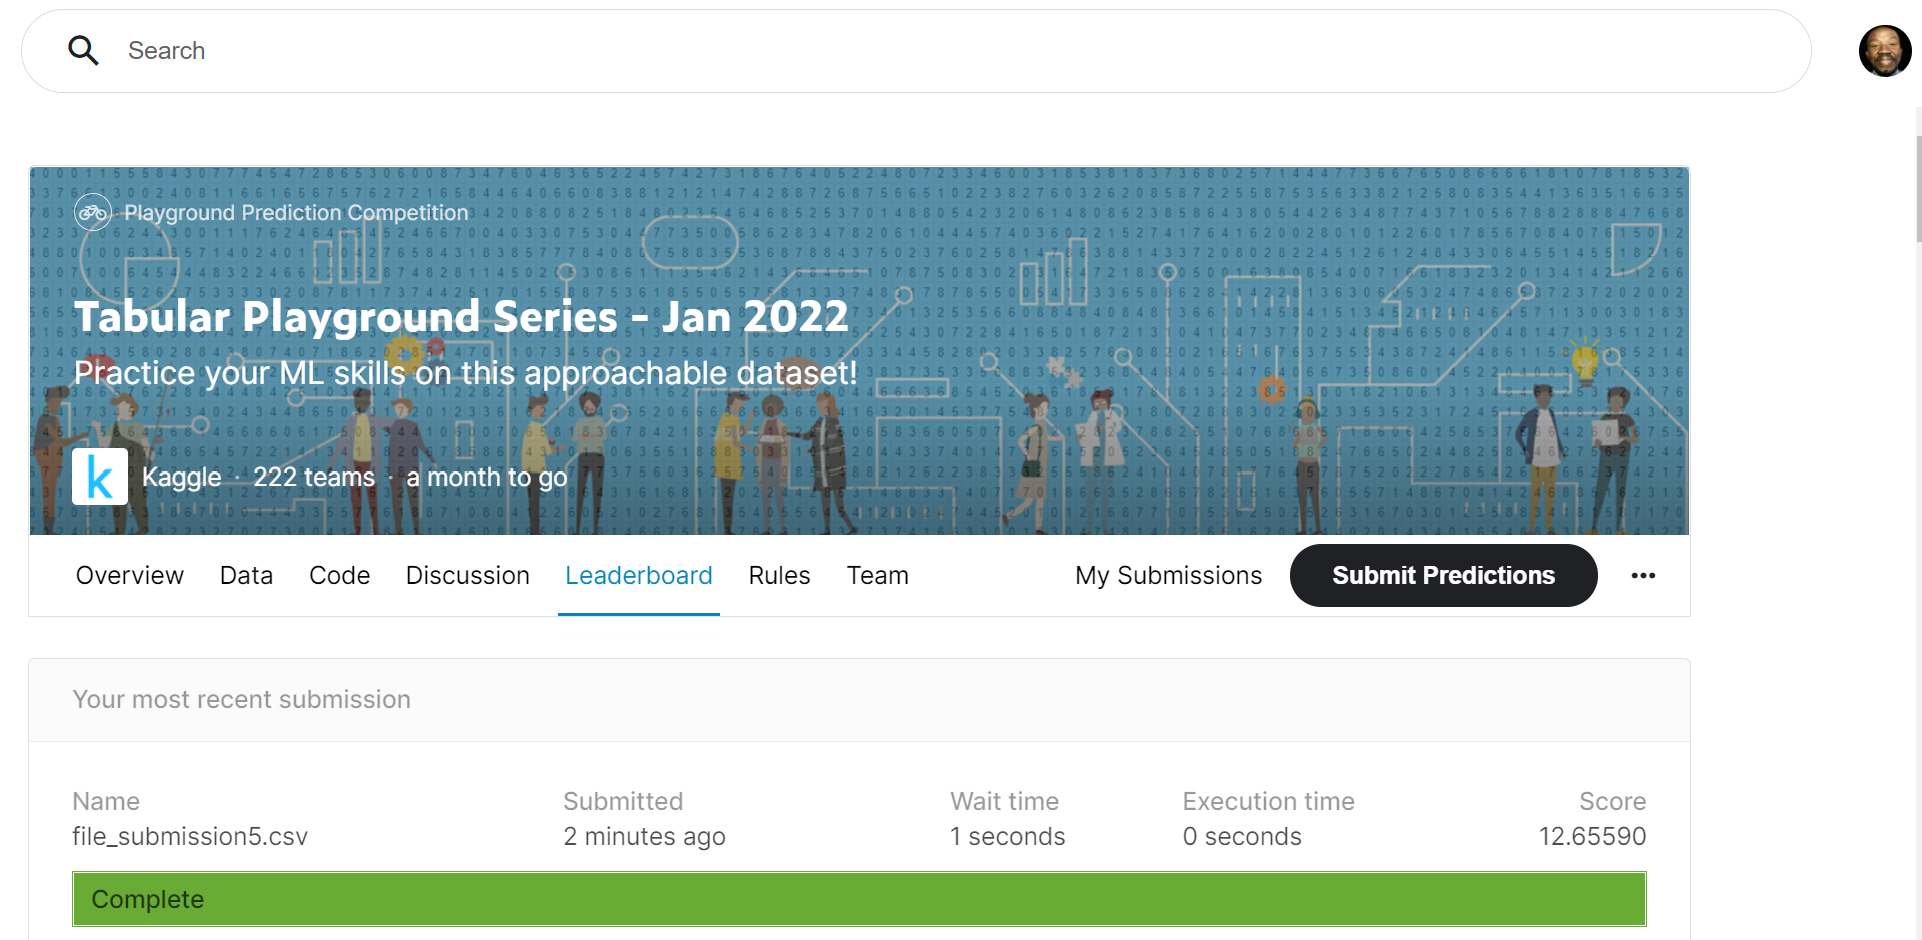

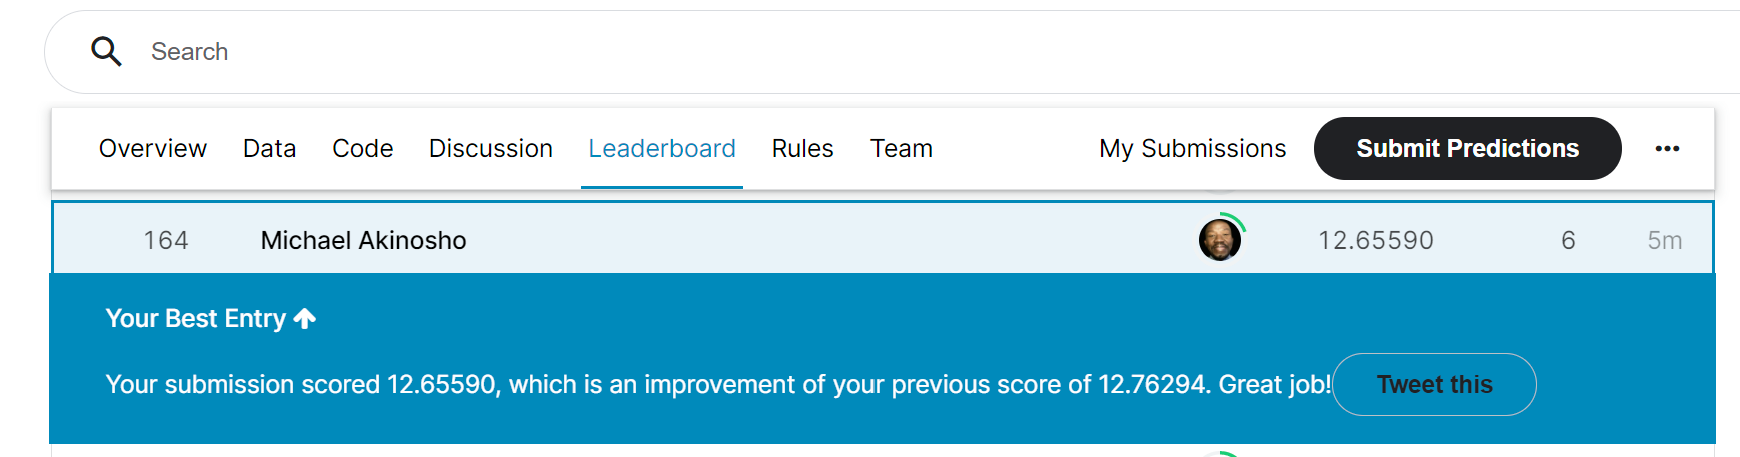